In [68]:
import json
from pathlib import Path
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from openai import OpenAI
from fast_pareto import is_pareto_front


In [70]:
def get_abc_estimate(fname):

    area = None
    delay = None
    with open(fname) as fin:
        for line in fin:
            if 'ABC: WireLoad' in line:
                numbers = re.findall(r"[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", line)
                area = float(numbers[-4])
                delay = float(numbers[-2])

    return area, delay


def get_sta_delay(fname):
    with open(fname) as fin:
        for line in fin:
            if 'data arrival time' in line:
                numbers = re.findall(r"[-+]?[.]?[\d]+(?:,\d\d\d)*[\.]?\d*(?:[eE][-+]?\d+)?", line)
                delay = float(numbers[0])
    return delay


def get_yosys_area(fname):
    with open(fname) as f:
        d = json.load(f)
        area = float(d['design']['area'])
    return area


def get_params(fname):
    with open(fname) as f:
        p = f.readline()
        p = p.strip().split(' ')
        return p

In [71]:
def get_pareto_points(dataframe):
    points = dataframe[['area', 'delay']]
    is_pareto = is_pareto_front(points)
    pareto_front = dataframe[is_pareto]
    return pareto_front

In [72]:
def get_points(dir_name):

    def get_type(x):
        type = str(Path(x).stem)
        return type
    
    areas = []
    features = []
    delays = []
    names = []
    blifs = []
    
    for k in range(10000000000):
    
        abc_file = f'{dir_name}/abc_{k}.log'
        sta_file = f'{dir_name}/sta_{k}.log'
        yosys_file = f'{dir_name}/yosys_{k}.json'
        params_file = f'{dir_name}/params_{k}.log'
        blif_file = f'{dir_name}/blif_{k}.log'
        
        try:
            abc_area, abc_delay = get_abc_estimate(abc_file)
            yosys_area = get_yosys_area(yosys_file)
            sta_delay = get_sta_delay(sta_file)
            params = get_params(params_file)
            areas.append(yosys_area)
            features.append(params)
            delays.append(sta_delay)
            names.append(params_file)
            blifs.append(blif_file)
        except:
            break
    
    features = np.array(features)
    
    df = pd.DataFrame(features, columns=['name', 'synth', 'abc_script'])
    df = df.astype({'synth': 'int32', 'abc_script': 'int32'})
    df['area'] = areas
    df['name'] = names
    df['delay'] = delays
    df['type'] = df.name.map(get_type)
    df['blif'] = blifs
    
    return df

16 16


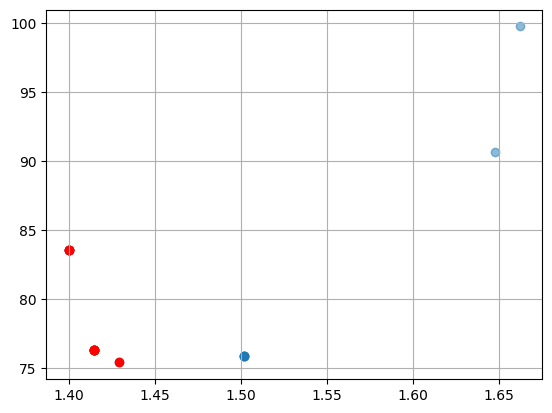

In [92]:
res_dir = 'bitwidth_4_output'
df = get_points(res_dir)
print(len(df.area), len(df.area))
pareto_front = get_pareto_points(df)

plt.scatter(df.area, df.delay, alpha=0.5)
plt.scatter(pareto_front.area, pareto_front.delay, c='r')
plt.grid()

[ True False  True  True False False  True  True  True  True  True False
 False False  True  True  True  True  True  True  True False  True  True
  True  True  True False False False  True  True False False False False
  True False False False  True False  True False False False  True  True
  True False  True False False False  True  True  True False  True False
 False False  True  True  True False  True False False False  True  True
  True False  True False False False  True  True  True  True  True  True
 False False  True  True  True False  True False False False  True  True
  True  True  True False False False  True  True  True  True  True  True
 False False  True  True]


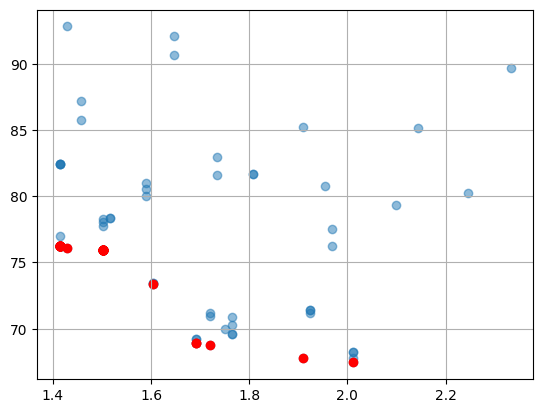

In [15]:
res_dir = 'bitwidth_4_output'
df = get_points(res_dir)

pareto_front = get_pareto_points(df)

plt.scatter(df.area, df.delay, alpha=0.5)
plt.scatter(pareto_front.area, pareto_front.delay, c='r')
plt.grid()

In [10]:
def get_yosys_area_fa(fname):
    with open(fname) as f:
        try:
            d = json.load(f)
            area = float(d['modules']['\\adder']['area'])
        except:
            area = None
    return area


def get_points_fa(dir_name):
    
    areas = []
    delays = []

    for yosys_file in sorted(Path(dir_name).rglob('*.json')):
        sta_file = str(yosys_file.with_suffix('.log')).replace('yosys', 'sta')
        
        try:
            yosys_area = get_yosys_area_fa(yosys_file)
            sta_delay = get_sta_delay(sta_file)
            areas.append(yosys_area)
            delays.append(sta_delay)
        except:
            break
    
    df = pd.DataFrame()
    df['area'] = areas
    df['delay'] = delays
    print(df.head)
    return df

<bound method NDFrame.head of         area  delay
0    1.41426  76.21
1    1.50174  75.54
2    1.50174  75.91
3    1.41426  76.21
4    1.60380  92.62
..       ...    ...
107  1.50174  75.95
108  1.41426  76.91
109  1.50174  75.20
110  1.41426  76.91
111  1.50174  75.61

[112 rows x 2 columns]>


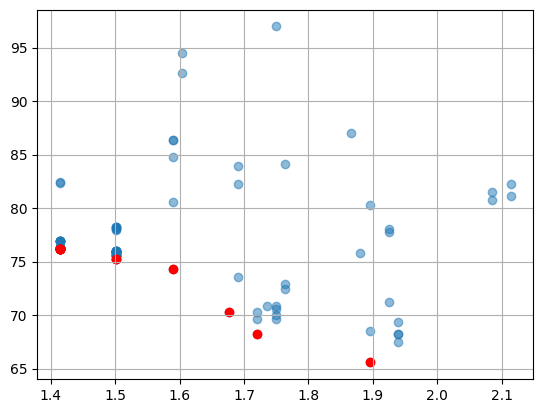

In [11]:
res_dir = 'bitwidth_4_fa'
df2 = get_points_fa(res_dir)

pareto_front2 = get_pareto_points(df2)

plt.scatter(df2.area, df2.delay, alpha=0.5)
plt.scatter(pareto_front2.area, pareto_front2.delay, c='r')
plt.grid()

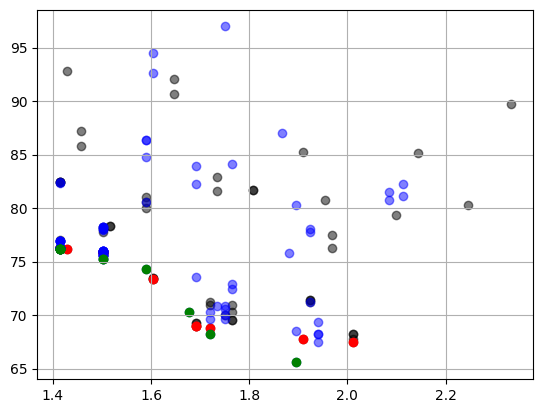

In [12]:
plt.scatter(df.area, df.delay, alpha=0.5, c='k')
plt.scatter(pareto_front.area, pareto_front.delay, c='r')

plt.scatter(df2.area, df2.delay, alpha=0.5, c='b')
plt.scatter(pareto_front2.area, pareto_front2.delay, c='g')

plt.grid()


Черные точки: точки из bitwidth_4_output

Синие точки: точки из bitwidth_4_fa

Красные точки: парето-фронт для bitwidth_4_output.

Зеленые точки: парето-фронт для bitwidth_4_fa
